In [2]:
#beta = [alpha, beta_1, \dots, beta_k]

def predict(x_i, beta):
    """assumes the first element of each x_i is 1"""
    return sum(x_ij*beta_j for x_ij, beta_j in zip(x_i,beta))


20

Let's construct an example of what happens when the columns of $x$ are: 
#1. not independent
#2. Correlated with the errors



#2

We expect that creating a model with a "missing" parameter should cause bias, let's explore an example using the social network  from p181 DSFS.

In the social network, we want to predict the number of minutes a user spends on the site using only a few parameters: the number of friends and the number of hours worked at their day job.  

Let's assume that:
    1. People who work more hours spend less time on the site. (negative correlation: work_hours and minutes)
    2. People with more friends tend to work more hours. (positive correlation: friends and work_hours)


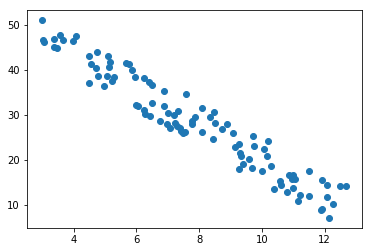

In [16]:
import random
from matplotlib import pyplot as plt


work_hours = [(random.random()+0.3)*10 for _ in range(100)]
minutes = [hrs*(-4)+60 + (random.random()-0.5)*10 for hrs in work_hours]

_, ax = plt.subplots()

ax.scatter(work_hours,minutes)

plt.show()